In [1]:
# Instalação de pacotes
# !pip install numpy==1.23.0
!pip install patchify

In [2]:
import datetime
import math
import os
import glob
import sys
from enum import Enum

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from keras import backend as K
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.models import Model, load_model
from keras.utils import to_categorical
from patchify import patchify
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from keras.layers import Rescaling
from tqdm import tqdm

import sklearn as sk
import tensorflow as tf
import pandas as pd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensor Flow Version: 2.11.0
Keras Version: 2.11.0

Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]
Pandas 1.5.3
Scikit-Learn 1.2.2
GPU is NOT AVAILABLE


In [71]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [4]:
# =======================================================
# image preprocessing

# def load_images_and_patchify(directory_path, patch_size, scale : int = 100, dataset_size_limit: int = 0):
#     """
#     :param patch_size: image patchify square size
#     :param directory_path: path to root directory containing training and test images
#     :param scale: reduce dimensions of the image using scale ratio passed in percent -> criado por Márcio d'El-Rei
#     :param dataset_size_limit: dataset size limit, if 0 all dataset is used -> criado por Márcio d'El-Rei
#     :return: list of images from directory
#     """

#     # initialize empty list for images
#     instances = []
    
#     # initialize empty list for images_names
#     list_images_names = []

#     size_count_limit = 1
    
#     # iterate through files in directory
#     for file_number, filepath in tqdm(enumerate(os.listdir(directory_path))):
#         name = os.path.basename(filepath)
#         list_images_names.append(name)
#         extension = filepath.split(".")[-1]
#         if extension == "jpg" or extension == "png":

#             # current image path
#             img_path = rf"{directory_path}/{filepath}"

#             # Reads image as BGR
#             image = cv2.imread(img_path)
            
#             # resize image
#             scale_percent = scale # percent of original size
#             width = int(image.shape[1] * scale_percent / 100)
#             height = int(image.shape[0] * scale_percent / 100)
#             dim = (width, height)
#             image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

#             # convert image to RBG
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#             size_x = (image.shape[1] // patch_size) * patch_size  # width to the nearest size divisible by patch size
#             size_y = (image.shape[0] // patch_size) * patch_size  # height to the nearest size divisible by patch size

#             image = Image.fromarray(image)

#             # Crop original image to size divisible by patch size from top left corner
#             image = np.array(image.crop((0, 0, size_x, size_y)))

#             # Extract patches from each image, step=patch_size means no overlap
#             patch_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

#             # iterate over vertical patch axis
#             for j in range(patch_img.shape[0]):
#                 # iterate over horizontal patch axis
#                 for k in range(patch_img.shape[1]):
#                     # patches are located like a grid. use (j, k) indices to extract single patched image
#                     single_patch_img = patch_img[j, k]

#                     # Drop extra dimension from patchify
#                     instances.append(np.squeeze(single_patch_img))
#             if dataset_size_limit == size_count_limit:
#                 break
#             size_count_limit += 1
            
#     return instances, list_images_names

def load_images_and_patchify(directory_path, patch_size, scale : int = 100, dataset_size_limit: int = 0):
    """
    :param patch_size: image patchify square size
    :param directory_path: path to root directory containing training and test images
    :param scale: reduce dimensions of the image using scale ratio passed in percent -> criado por Márcio d'El-Rei
    :param dataset_size_limit: dataset size limit, if 0 all dataset is used -> criado por Márcio d'El-Rei
    :return: list of images from directory
    """

    # initialize empty list for images
    instances = []
    
    # initialize empty list for images_names
    list_images_names = []

    size_count_limit = 1
    # Get list of all files in a given directory & sub-directories sorted by name
    list_of_files = sorted( filter( os.path.isfile,
                        glob.glob(directory_path + '/**/*', recursive=True) ) )

    # iterate through files in directory
    for file_number, filepath in tqdm(enumerate(list_of_files)):
        name = os.path.basename(filepath)
        list_images_names.append(name)
        extension = filepath.split(".")[-1]
        if extension == "jpg" or extension == "png":

            # current image path
            img_path = filepath

            # Reads image as BGR
            image = cv2.imread(img_path)
            
            # resize image
            scale_percent = scale # percent of original size
            width = int(image.shape[1] * scale_percent / 100)
            height = int(image.shape[0] * scale_percent / 100)
            dim = (width, height)
            image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

            # convert image to RBG
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            size_x = (image.shape[1] // patch_size) * patch_size  # width to the nearest size divisible by patch size
            size_y = (image.shape[0] // patch_size) * patch_size  # height to the nearest size divisible by patch size

            image = Image.fromarray(image)

            # Crop original image to size divisible by patch size from top left corner
            image = np.array(image.crop((0, 0, size_x, size_y)))

            # Extract patches from each image, step=patch_size means no overlap
            patch_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

            # iterate over vertical patch axis
            for j in range(patch_img.shape[0]):
                # iterate over horizontal patch axis
                for k in range(patch_img.shape[1]):
                    # patches are located like a grid. use (j, k) indices to extract single patched image
                    single_patch_img = patch_img[j, k]

                    # Drop extra dimension from patchify
                    instances.append(np.squeeze(single_patch_img))
            if dataset_size_limit == size_count_limit:
                break
            size_count_limit += 1
            
    return instances, list_images_names


def reshape_images(instances):
    """
    :param instances: list of images
    :return: reshaped images
    """
    for j in range(len(instances)):
        instances[j] = instances[j].reshape(-1, 1)
    return instances


def get_minimum_image_size(instances):
    """
    :param instances: list of images
    :return: min and max dimensions out of all images
    """

    # initialize minimum values to infinity
    min_x = math.inf
    min_y = math.inf

    # loop through each instance
    for image in instances:
        # check min x (rows)
        min_x = image.shape[0] if image.shape[0] < min_x else min_x

        # check min y (columns)
        min_y = image.shape[1] if image.shape[1] < min_y else min_y

    return min_x, min_y


def display_images(instances, rows=2, titles=None):
    """
    :param instances:  list of images
    :param rows: number of rows in subplot
    :param titles: subplot titles
    :return:
    """
    n = len(instances)
    cols = n // rows if (n / rows) % rows == 0 else (n // rows) + 1

    # iterate through images and display subplots
    for j, image in enumerate(instances):
        plt.subplot(rows, cols, j + 1)
        plt.title('') if titles is None else plt.title(titles[j])
        plt.axis("off")
        plt.imshow(image)

    # show the figure
    plt.show()

In [11]:
# =====================================================
# prepare training data input images

# def get_training_data(root_directory):
#     # initialise lists
#     image_dataset, mask_dataset = [], []

#     # define image patch size
#     patch_size = 200

#     # walk through root directory
#     for path, directories, files in os.walk(root_directory):
#         for subdirectory in directories:

#             # extract training input images and patchify
#             if subdirectory == "images":
#                 image_dataset.extend(
#                     load_images_and_patchify(os.path.join(path, subdirectory), patch_size=patch_size, scale=30, dataset_size_limit=10))

#             # extract training label masks and patchify
#             elif subdirectory == "masks":
#                 mask_dataset.extend(
#                     load_images_and_patchify(os.path.join(path, subdirectory), patch_size=patch_size, scale=30, dataset_size_limit=10))

#     # return input images and masks
#     return np.array(image_dataset), np.array(mask_dataset)


def get_training_data(root_directory, patchify_pixels_size: int = patch_size, scale: int = 100, dataset_size_limit: int = 0):
    # initialise lists
    image_dataset, mask_dataset = [], []

    # define image patch size
    patch_size = patchify_pixels_size

    # walk through root directory
    for path, directories, files in os.walk(root_directory):
        for subdirectory in directories:

            # extract training input images and patchify
            print("<i>Loading and patchify images.../>")
            if subdirectory == "images":
                image_list, image_names_list = load_images_and_patchify(os.path.join(path, subdirectory), patch_size=patch_size, scale=scale, dataset_size_limit=dataset_size_limit)
                image_dataset.extend(image_list)
                    

            # extract training label masks and patchify
            print("<i>Loading and patchify masks.../>")
            elif subdirectory == "masks":
                mask_list, mask_names_list = load_images_and_patchify(os.path.join(path, subdirectory), patch_size=patch_size, scale=scale, dataset_size_limit=dataset_size_limit)
                mask_dataset.extend(mask_list)

    # return input images and masks
    return np.array(image_dataset), np.array(mask_dataset), image_names_list, mask_names_list

# Não usado por enquanto
def create_binary_segmentation_problem(image_dataset, mask_dataset):
    # change problem to binary segmentation problem
    x_reduced, y_reduced = [], []

    # iterate over masks
    for j, mask in tqdm(enumerate(mask_dataset)):

        # get image shape
        _img_height, _img_width, _img_channels = mask.shape

        # create binary image (zeros)
        binary_image = np.zeros((_img_height, _img_width, 1)).astype(int)

        # iterate over each pixel in mask
        for row in range(_img_height):
            for col in range(_img_width):
                # get image channel across axis=3
                rgb = mask[row, col, :]

                # building hex: #3C1098 = RGB(60, 16, 152) or BGR(152, 16, 60)
                binary_image[row, col] = 1 if rgb[0] == 60 and rgb[1] == 16 and rgb[2] == 152 else 0

        # only keep images with a high percentage of building coverage
        if np.count_nonzero(binary_image == 1) > 0.15 * binary_image.size:
            x_reduced.append(image_dataset[j])
            y_reduced.append(binary_image)

    # return binary image dataset
    return np.array(x_reduced), np.array(y_reduced)


# mask color codes
# class MaskColorMap(Enum):
#     Unlabelled = (155, 155, 155)
#     Building = (60, 16, 152)
#     Land = (132, 41, 246)
#     Road = (110, 193, 228)
#     Vegetation = (254, 221, 58)
#     Water = (226, 169, 41)

class MaskColorMap(Enum):
    unlabeled = (0, 0, 0)
    paved_area = (128, 64, 128)
    dirt = (130, 76, 0)
    grass = (0, 102, 0)
    gravel = (112, 103, 87)
    water = (28, 42, 168)
    rocks = (48, 41, 30)
    pool = (0, 50, 89)
    vegetation = (107, 142, 35)
    roof = (70, 70, 70)
    wall = (102, 102, 156)
    window = (254, 228, 12)
    door = (254, 148, 12)
    fence = (190, 153, 153)
    fence_pole = (153, 153, 153)
    person = (255, 22, 96)
    dog = (102, 51, 0)
    car = (9, 143, 150)
    bicycle = (119, 11, 32)
    tree = (51, 51, 0)
    bald_tree = (190, 250, 190)
    ar_marker = (112, 150, 146)
    obstacle = (2, 135, 115)
    conflicting = (255, 0, 0)



def one_hot_encode_masks(masks, num_classes):
    """
    :param masks: Y_train patched mask dataset
    :param num_classes: number of classes
    :return:
    """
    # initialise list for integer encoded masks
    integer_encoded_labels = []

    # iterate over each mask
    for mask in tqdm(masks):

        # get image shape
        _img_height, _img_width, _img_channels = mask.shape

        # create new mask of zeros
        encoded_image = np.zeros((_img_height, _img_width, 1)).astype(int)

        for j, cls in enumerate(MaskColorMap):
            encoded_image[np.all(mask == cls.value, axis=-1)] = j

        # append encoded image
        integer_encoded_labels.append(encoded_image)

    # return one-hot encoded labels
    return to_categorical(y=integer_encoded_labels, num_classes=num_classes)

SyntaxError: invalid syntax (2865852897.py, line 49)

In [6]:
def get_dt_now_formatted() -> str:
    dt_now = str(datetime.datetime.now())
    dt_now = dt_now.replace("-","")
    dt_now = dt_now.replace(" ","_")
    dt_now = dt_now.replace(":","")
    dt_now = dt_now.replace(".","")
    print(dt_now)
    return dt_now

In [7]:
import os
os.getcwd()


'/kaggle/working'

In [8]:
# =====================================================
# output directories

# datetime for filename saving
dt_now = get_dt_now_formatted()
current_dir = os.getcwd()
models_dir = "models"
logs_dir = "logs"
if not os.path.exists(os.path.join(current_dir, models_dir)):
    os.mkdir(os.path.join(current_dir, models_dir))

if not os.path.exists(os.path.join(current_dir, logs_dir)):
    os.mkdir(os.path.join(current_dir, logs_dir))
                      
file_name_save = f"final_aerial_segmentation_{dt_now}"
model_img_save_path = os.path.join(current_dir, models_dir, f"{file_name_save}.png")
model_save_path = os.path.join(current_dir, models_dir, f"{file_name_save}.hdf5")
model_checkpoint_filepath = os.path.join(current_dir, models_dir, "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5")
csv_logger = os.path.join(current_dir, logs_dir, f"aerial_segmentation_log_{dt_now}.csv")


20230513_100405646224


In [9]:
# =======================================================
# training metrics

# Mean Intersection-Over-Union: iou = true_positives / (true_positives + false_positives + false_negatives)
def iou_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, [1, 2, 3]) + K.sum(y_pred, [1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


# jaccard similarity: the size of the intersection divided by the size of the union of two sets
def jaccard_index(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [55]:
# Patch size in pixels
patch_size = 256

In [56]:
# ===================DEBUG==================================
# get training data

# number of classes in segmentation dataset
n_classes = 24

# dataset directory
# data_dir = "semantic_segmentation_dataset"
data_dir = "/kaggle/input/drone-aerial-semantic-segmentation/semantic"

# create (X, Y) training data
X = None
Y = None
X, Y, image_name_list, mask_name_list = get_training_data(root_directory=data_dir, patchify_pixels_size=patch_size, scale=30, dataset_size_limit=10)

print("Used memory to store the 8 bit int image dataset is: ", X.nbytes/(1024*1024), "MB")
print("Used memory to store the 8 bit int mask dataset is: ", Y.nbytes/(1024*1024), "MB")

# extract X_train shape parameters
m, img_height, img_width, img_channels = X.shape
print('number of patched image training data:', m)

print(image_name_list)
print(mask_name_list)

9it [00:06,  1.43it/s]
9it [00:04,  1.96it/s]

Used memory to store the 8 bit int image dataset is:  52.5 MB
Used memory to store the 8 bit int mask dataset is:  52.5 MB
number of patched image training data: 280
['000.jpg', '001.jpg', '002.jpg', '003.jpg', '004.jpg', '005.jpg', '006.jpg', '008.jpg', '011.jpg', '013.jpg']
['000.png', '001.png', '002.png', '003.png', '004.png', '005.png', '006.png', '008.png', '011.png', '013.png']


X len: 280
Y len: 280
174


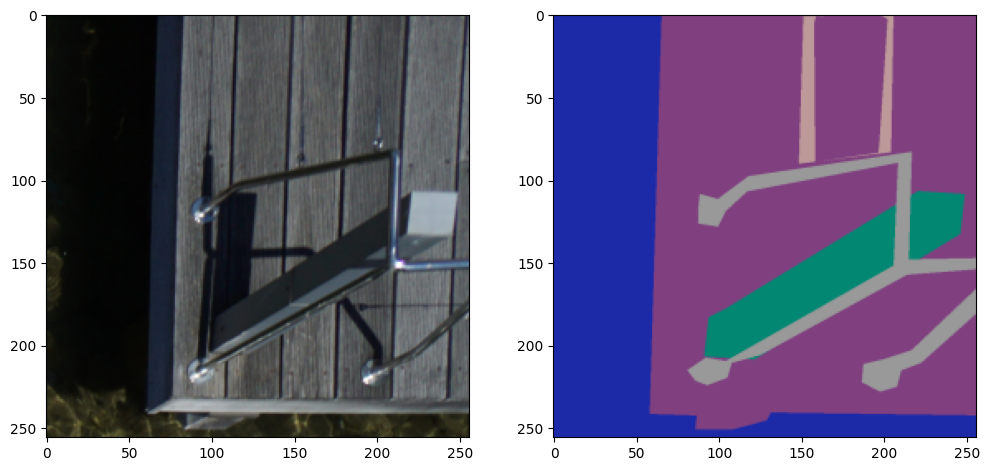

In [58]:
image_number = np.random.randint(0, len(X))
print(f"X len: {len(X)}")
print(f"Y len: {len(Y)}")
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.imshow(X[image_number])
plt.subplot(1,2,2)
plt.imshow(Y[image_number])
plt.show()

[64, 181, 0, 0, 40, 129]


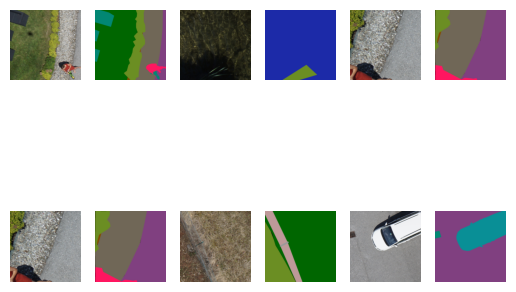

In [59]:
# display images from both training and test sets
display_count = 6
random_index = [np.random.randint(0, m) for _ in range(display_count)]
print(random_index)
sample_images = [x for z in zip(list(X[random_index]), list(Y[random_index])) for x in z]
display_images(sample_images, rows=2)

In [60]:
# =====================================================
# get training data - continue

# convert RGB values to integer encoded labels for categorical_crossentropy
Y = one_hot_encode_masks(Y, num_classes=n_classes)

# split dataset into training and test groups
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)


100%|██████████| 280/280 [00:18<00:00, 14.77it/s]


In [61]:
X_train.shape

(196, 256, 256, 3)

In [62]:
Y_train.shape

(196, 256, 256, 24)

In [63]:
# =====================================================
# define U-Net model architecture

def build_unet(img_shape):
    # input layer shape is equal to patch image size
    inputs = Input(shape=img_shape)

    # rescale images from (0, 255) to (0, 1)
    rescale = Rescaling(scale=1. / 255, input_shape=(img_height, img_width, img_channels))(inputs)
    previous_block_activation = rescale  # Set aside residual

    print("Contraction operation start...")
    contraction = {}
    # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
    for f in [16, 32, 64, 128]:
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
            previous_block_activation)
        print(x.shape)
        x = Dropout(0.1)(x)
        print(x.shape)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        print(x.shape)
        contraction[f'conv{f}'] = x
        print(x.shape)
        x = MaxPooling2D((2, 2))(x)
        print(x.shape)
        previous_block_activation = x
        print(previous_block_activation.shape)

    c5 = Conv2D(patch_size, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
        previous_block_activation)
#     print(c5.shape)
    c5 = Dropout(0.2)(c5)
#     print(c5.shape)
    c5 = Conv2D(patch_size, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5
#     print(previous_block_activation.shape)

    print(contraction)
    print()

    print("Expantion operation start...")
    # Expansive path: Second half of the network: upsampling inputs
    for f in reversed([16, 32, 64, 128]):
        x = Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
        print(x.shape)
        print(f'conv{f}')
        x = concatenate([x, contraction[f'conv{f}']])
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(0.2)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    outputs = Conv2D(filters=n_classes, kernel_size=(1, 1), activation="softmax")(previous_block_activation)

    return Model(inputs=inputs, outputs=outputs)


In [64]:
# build model
model = build_unet(img_shape=(img_height, img_width, img_channels))
model.summary()

Contraction operation start...
(None, 256, 256, 16)
(None, 256, 256, 16)
(None, 256, 256, 16)
(None, 256, 256, 16)
(None, 128, 128, 16)
(None, 128, 128, 16)
(None, 128, 128, 32)
(None, 128, 128, 32)
(None, 128, 128, 32)
(None, 128, 128, 32)
(None, 64, 64, 32)
(None, 64, 64, 32)
(None, 64, 64, 64)
(None, 64, 64, 64)
(None, 64, 64, 64)
(None, 64, 64, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 128)
(None, 32, 32, 128)
(None, 32, 32, 128)
(None, 32, 32, 128)
(None, 16, 16, 128)
(None, 16, 16, 128)
{'conv16': <KerasTensor: shape=(None, 256, 256, 16) dtype=float32 (created by layer 'conv2d_120')>, 'conv32': <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'conv2d_122')>, 'conv64': <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'conv2d_124')>, 'conv128': <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'conv2d_126')>}

Expantion operation start...
(None, 32, 32, 128)
conv128
(None, 64, 64, 64)
conv64
(None, 1

In [ ]:
# =======================================================
# add callbacks, compile model and fit training data

# save best model with maximum validation accuracy
checkpoint = ModelCheckpoint(model_checkpoint_filepath, monitor="val_accuracy", verbose=1, save_best_only=True,
                             mode="max")

# stop model training early if validation loss doesn't continue to decrease over 2 iterations
early_stopping = EarlyStopping(monitor="val_loss", patience=2, verbose=1, mode="min")

# log training console output to csv
csv_logger = CSVLogger(csv_logger, separator=";", append=False)

# create list of callbacks
callbacks_list = [checkpoint, csv_logger]  # early_stopping

# compile model
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy", iou_coefficient, jaccard_index])

# train and save model
model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test), callbacks=callbacks_list,
          verbose=1)
model.save(model_save_path)
print("model saved:", model_save_path)


Epoch 1/20
1/7 [===>..........................] - ETA: 2:11 - loss: 3.3370 - accuracy: 0.0267 - iou_coefficient: 0.0186 - jaccard_index: 0.0186

In [ ]:
# =====================================================
# load pre-trained model

# model_dir = '/Users/andrewdavies/Code/tensorflow-projects/u-net-aerial-imagery-segmentation/models/'
model_dir = 'models/'
model_name = 'final_aerial_segmentation_20230507_192936400066.hdf5'

# model = load_model(
#     model_dir + model_name,
#     custom_objects={'iou_coefficient': iou_coefficient, 'jaccard_index': jaccard_index}
# )
    

In [ ]:
# =====================================================
# Predict

def rgb_encode_mask(mask):
    # initialize rgb image with equal spatial resolution
    rgb_encode_image = np.zeros((mask.shape[0], mask.shape[1], 3))

    # iterate over MaskColorMap
    for j, cls in enumerate(MaskColorMap):
        # convert single integer channel to RGB channels
        rgb_encode_image[(mask == j)] = np.array(cls.value) / 255.
    return rgb_encode_image

def predict_model_just_created(use_model: Model):
    if use_model is None:
        model_dir = 'models/'
        model_name = 'final_aerial_segmentation_2022-11-09 22_37_27_640199.hdf5'
        use_model = load_model(
            model_dir + model_name,
            custom_objects={'iou_coefficient': iou_coefficient, 'jaccard_index': jaccard_index})

    for _ in range(20):
        # choose random number from 0 to test set size
        test_img_number = np.random.randint(0, len(X_test))

        # extract test input image
        test_img = X_test[test_img_number]

        # ground truth test label converted from one-hot to integer encoding
        ground_truth = np.argmax(Y_test[test_img_number], axis=-1)

        # expand first dimension as U-Net requires (m, h, w, nc) input shape
        test_img_input = np.expand_dims(test_img, 0)

        # make prediction with model and remove extra dimension
        # prediction = np.squeeze(model.predict(test_img_input))
        prediction = np.squeeze(use_model.predict(test_img_input))

        # convert softmax probabilities to integer values
        predicted_img = np.argmax(prediction, axis=-1)

        # convert integer encoding to rgb values
        rgb_image = rgb_encode_mask(predicted_img)
        rgb_ground_truth = rgb_encode_mask(ground_truth)

        # visualize model predictions
        display_images(
            [test_img, rgb_ground_truth, rgb_image],
            rows=1, titles=['Aerial', 'Ground Truth', 'Prediction']
        )


In [ ]:
def predict(dir_images, use_model : Model = None):
    if use_model is None:
        model_dir = 'models/'
        model_name = 'final_aerial_segmentation_20230507_192936400066.hdf5'
        use_model = load_model(
            model_dir + model_name,
            custom_objects={'iou_coefficient': iou_coefficient, 'jaccard_index': jaccard_index})
    
    # print(use_model.summary())
    # dir_images = sorted(dir_images,)
    # predict images
    predicted_imgs = []
    for img_path in dir_images:
        print(img_path)
        img = cv2.imread(img_path)
        sample_images=[img]
        display_images(sample_images, rows=1)

        
        img_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        sample_images=[img_original]
        display_images(sample_images, rows=1)
        
        img_resized = cv2.resize(img_original, (160, 160))
        sample_images=[img_resized]
        display_images(sample_images, rows=1)

        # img = img / 255
        # sample_images=[img]
        # display_images(sample_images, rows=1)

        img = np.expand_dims(img_resized, axis=0)
        sample_images=[img]
        # display_images(sample_images, rows=1)

        # img = np.expand_dims(img, axis=3)
        img = img.astype(np.float32)
        sample_images=[img]
        # display_images(sample_images, rows=1)
        
        # make prediction with model and remove extra dimension
        # prediction = np.squeeze(model.predict(test_img_input))
        prediction = np.squeeze(use_model.predict(img))
        sample_images=[prediction]
        # display_images(sample_images, rows=1)

        predicted_imgs.append(prediction)

        # convert softmax probabilities to integer values
        predicted_img = np.argmax(prediction, axis=-1)
        print(predicted_img.shape)
        sample_images=[predicted_img]
        display_images(sample_images, rows=1)

        # convert integer encoding to rgb values
        rgb_image = rgb_encode_mask(predicted_img)
        sample_images=[rgb_image]
        display_images(sample_images, rows=1)

        # visualize model predictions
        display_images(
            [img_resized, rgb_image],
            rows=1, titles=['Aerial', 'Prediction']
        )

In [ ]:
dir_images = [r"D:\source\20230507_TCC\dataset\20161112_sample_01\DJI_0140.JPG"]
model_dir = 'models/'
model_name = r"final_aerial_segmentation_2022-11-09 22_37_27_640199.hdf5"
use_model = load_model(
    model_dir + model_name,
    custom_objects={'iou_coefficient': iou_coefficient, 'jaccard_index': jaccard_index})
predict(dir_images, use_model)

model_name = r"final_aerial_segmentation_20230507_192936400066.hdf5"
use_model = load_model(
    model_dir + model_name,
    custom_objects={'iou_coefficient': iou_coefficient, 'jaccard_index': jaccard_index})
predict(dir_images, use_model)